In [19]:
import numpy as np
import pybamm
import matplotlib.pyplot as plt
from utils.generate_new_volume import generate_new_volume
from utils.physical_properties import *
from skimage.transform import rescale, downscale_local_mean

# 4 phase volumes
phases = ['Pore','Crack','Particle','CBD']

# Volume generation
def generate_new_volume_rve(reduction, subregion_id, subregion):
    model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
    model_path = 'model/{}/{}'.format(model_name, model_name)

    # Need to modify output size so the size of the generated volume is the same regardless of training image resolution
    lz = int(20 * reduction) # default 8 at 20% reduction
    vol = generate_new_volume(model_path=model_path, lz=lz)
    # downscale higher resolution images to avoid taking a really long time, rounding to preseve segmented
    if reduction > 0.2:
        reduced = rescale(vol, 0.2/reduction)
    else:
        reduced = vol
    return vol, reduced

# Diffusivity function to modify for Pybamm
def lico2_diffusivity(sto, T, coeff):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    #D_ref = 1 * 10 ** (-13)
    D_ref = (coeff / 0.4) * 10 ** (-13) # 0.4 is a random number picked from some GAN runs
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def properties_and_echem_from_volume(reduction, subregion_id, subregion, n=10, is_plot=True):
    capacities = np.zeros((n,1))
    vfs_particle = np.zeros((n,1))
    vfs_pore = np.zeros((n,1))
    D_effs = np.zeros((n,1))

    for i in range(n):
        vol, vol_reduced = generate_new_volume_rve(reduction, subregion_id, subregion)
        vol = vol_reduced
        '''
        Properties to modify:
        - Positive electrode porosity
        - Positive electrode active material volume fraction
        Things to work on later:
        - inputting Deff into positive electrode diffusivity (need to modify function in parameters)
        - inputting particle size (current volume is too small to have 'particles')
            - use surface area to reverse calculate particle size? particle size controls surface area in pybamm (sphere = 3/(r*(1-vf_pore)))
        '''
        # Set all cracks and pores equal for porosity
        vol[vol==1] = 0
        vf_particle = volume_fraction(vol, phase_class=2)
        vf_pore     = volume_fraction(vol, phase_class=0)
        # # pybamm can fail at extreme values
        # if vf_particle > 0.85:
        #     vf_particle = 0.85
        # if vf_pore < 0.09:
        #     vf_pore = 0.09

        # Diffusivity and tortuosity
        # Set all phases to 0 except particle for taufactor
        vol[vol==3] = 0
        vol[vol==2] = 1
        homogenized_properties = compute_tau_and_D_eff(vol, verbose=False)
        D_eff = homogenized_properties['D_eff'].item()

        vfs_particle[i] = vf_particle
        vfs_pore[i] = vf_pore
        D_effs[i] = D_eff

        # PyBaMM model
        model = pybamm.lithium_ion.DFN()
        # Default parameter set
        params = pybamm.ParameterValues("Marquis2019")
        # Modify parameters
        params['Positive electrode porosity'] = vf_pore
        params['Positive electrode active material volume fraction'] = vf_particle
        params['Positive electrode diffusivity [m2.s-1]'] = lambda sto, T: lico2_diffusivity(sto, T, D_eff)
        # Run the simulation
        sim = pybamm.Simulation(model,parameter_values=params)
        sim.solve([0, 7200],initial_soc=1)
        sol = sim.solution
        # Save the discharge capacity
        capacities[i] = sol['Discharge capacity [A.h]'].entries[-1]

        # Plot to see if the simulations are any different
        if is_plot:
            plt.plot(sol['Discharge capacity [A.h]'].entries, sol['Voltage [V]'].entries)

    if is_plot:
        plt.show()
    
    return capacities, vfs_particle, vfs_pore, D_effs


In [20]:
reduction = [1.0, 0.8, 0.6, 0.4, 0.2]
for red in reduction:
    vol, vol_reduced = generate_new_volume_rve(red, 1, 1)
    path = 'img/slicegan_r{}_s{}{}_slice.png'.format(str(red).replace('.', 'p'), str(1), str(1))
    
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(vol[10, :, :], cmap = 'gray')
    ax[1].imshow(vol[:, 10, :], cmap = 'gray')
    ax[2].imshow(vol[:, :, 10], cmap = 'gray')
    plt.savefig(path)
    plt.close()

In [50]:
reduction = 0.2
subregion = 1
subregion_id = 1

model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
model_path = 'model/{}/{}'.format(model_name, model_name)

# Need to modify output size so the size of the generated volume is the same regardless of training image resolution
lz = int(40 * reduction) # default 8 at 20% reduction
vol = generate_new_volume(model_path=model_path, lz=lz)

# downscale
vol_ = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)

vol.shape, vol_.shape, np.unique(vol), np.unique(vol_)

((192, 192, 192),
 (192, 192, 192),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3]))

In [37]:
reduction = 0.4
subregion = 1
subregion_id = 1

model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
model_path = 'model/{}/{}'.format(model_name, model_name)

# Need to modify output size so the size of the generated volume is the same regardless of training image resolution
lz = int(40 * reduction) # default 8 at 20% reduction
vol = generate_new_volume(model_path=model_path, lz=lz)

# downscale
vol_ = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)

vol.shape, vol_.shape, np.unique(vol), np.unique(vol_)

((448, 448, 448),
 (224, 224, 224),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3]))

In [38]:
reduction = 0.6
subregion = 1
subregion_id = 1

model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
model_path = 'model/{}/{}'.format(model_name, model_name)

# Need to modify output size so the size of the generated volume is the same regardless of training image resolution
lz = int(40 * reduction) # default 8 at 20% reduction
vol = generate_new_volume(model_path=model_path, lz=lz)

# downscale
vol_ = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)

vol.shape, vol_.shape, np.unique(vol), np.unique(vol_)

((704, 704, 704),
 (352, 352, 352),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3]))

In [40]:
reduction = 0.8
subregion = 1
subregion_id = 1

model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
model_path = 'model/{}/{}'.format(model_name, model_name)

# Need to modify output size so the size of the generated volume is the same regardless of training image resolution
lz = int(40 * reduction) # default 8 at 20% reduction
vol = generate_new_volume(model_path=model_path, lz=lz)

# downscale
vol_ = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)

vol.shape, vol_.shape, np.unique(vol), np.unique(vol_)

((704, 704, 704),
 (176, 176, 176),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3]))

In [55]:
reduction = 1.0
subregion = 1
subregion_id = 1

model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
model_path = 'model/{}/{}'.format(model_name, model_name)

# Need to modify output size so the size of the generated volume is the same regardless of training image resolution
lz = int(40 * reduction) # default 8 at 20% reduction
vol = generate_new_volume(model_path=model_path, lz=lz)

# downscale
vol_ = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)

vol.shape, vol_.shape, np.unique(vol), np.unique(vol_)

((192, 192, 192),
 (39, 39, 39),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3]))

In [35]:
reductions =        (0.2, 0.4, 0.6, 0.8, 1.0)
im_gen_shapes =     (0.2, 0.4, 0.6, 704, 1.0)
im_final_shapes =   (0.2, 0.4, 0.6, 176, 1.0)

3.6666666666666665

At t = 490.767 and h = 2.17794e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.858 and h = 2.85789e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 517.575 and h = 2.99075e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 226.666 and h = 1.90016e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 561.539 and h = 3.53232e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 270.63 and h = 5.8215e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 125.175 and h = 8.20624e-23, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 531.587 and h = 5.68123e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 240.678 and h = 8.45701e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 95.223 and h = 6.05269e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At 

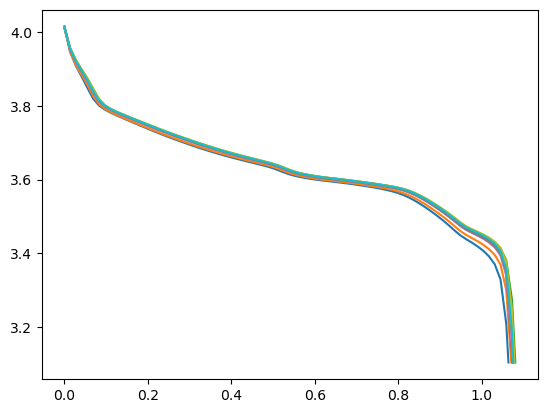

(array([[1.06396494],
        [1.07072614],
        [1.08036791],
        [1.07437467],
        [1.07528251],
        [1.07330247],
        [1.0739616 ],
        [1.07501588],
        [1.07851508],
        [1.07558733]]),
 array([[0.66200878],
        [0.68291134],
        [0.71626112],
        [0.69364873],
        [0.69709665],
        [0.68877835],
        [0.69251195],
        [0.69634798],
        [0.70845738],
        [0.69749394]]),
 array([[0.12802943],
        [0.1258381 ],
        [0.12524569],
        [0.13289784],
        [0.13148131],
        [0.1413659 ],
        [0.13136998],
        [0.12993057],
        [0.13198711],
        [0.13569613]]),
 array([[0.19670591],
        [0.1780802 ],
        [0.24974024],
        [0.21780851],
        [0.21669808],
        [0.20359418],
        [0.21022902],
        [0.22961044],
        [0.23841918],
        [0.21940938]]))

In [4]:
reduction = 0.2
subregion = 1
subregion_id = 1

properties_and_echem_from_volume(reduction, subregion_id, subregion)

In [7]:
reduction = 0.4
subregion = 1
subregion_id = 1

properties_and_echem_from_volume(reduction, subregion_id, subregion)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.